In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import K2Score
from sklearn.preprocessing import KBinsDiscretizer


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\Diabetic_Ground_Truth.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               905 non-null    int64  
 1   Gender            905 non-null    int64  
 2   Family_Diabetes   905 non-null    int64  
 3   highBP            905 non-null    int64  
 4   PhysicallyActive  905 non-null    int64  
 5   BMI               905 non-null    float64
 6   Smoking           905 non-null    int64  
 7   Alcohol           905 non-null    int64  
 8   Sleep             905 non-null    int64  
 9   SoundSleep        905 non-null    int64  
 10  RegularMedicine   905 non-null    int64  
 11  JunkFood          905 non-null    int64  
 12  Stress            905 non-null    int64  
 13  BPLevel           905 non-null    int64  
 14  Pregnancies       905 non-null    float64
 15  Pdiabetes         905 non-null    int64  
 16  UriationFreq      905 non-null    int64  
 1

Learning the structure of the Bayesian Network...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 27/1000000 [00:02<25:20:01, 10.96it/s]


Bayesian Network Structure:
[('Age', 'BPLevel'), ('Age', 'JunkFood'), ('BPLevel', 'highBP'), ('Gender', 'Pregnancies'), ('Gender', 'Alcohol'), ('Gender', 'Smoking'), ('Gender', 'RegularMedicine'), ('Pregnancies', 'Diabetic'), ('Alcohol', 'Smoking'), ('Smoking', 'Age'), ('Smoking', 'Stress'), ('Smoking', 'Family_Diabetes'), ('Smoking', 'PhysicallyActive'), ('RegularMedicine', 'Stress'), ('highBP', 'RegularMedicine'), ('Sleep', 'SoundSleep'), ('SoundSleep', 'UriationFreq'), ('UriationFreq', 'PhysicallyActive'), ('UriationFreq', 'Gender'), ('UriationFreq', 'Stress'), ('Diabetic', 'RegularMedicine'), ('Diabetic', 'Age'), ('Diabetic', 'Family_Diabetes'), ('Diabetic', 'Alcohol'), ('Diabetic', 'BPLevel'), ('Diabetic', 'PhysicallyActive'), ('Pdiabetes', 'Gender')]


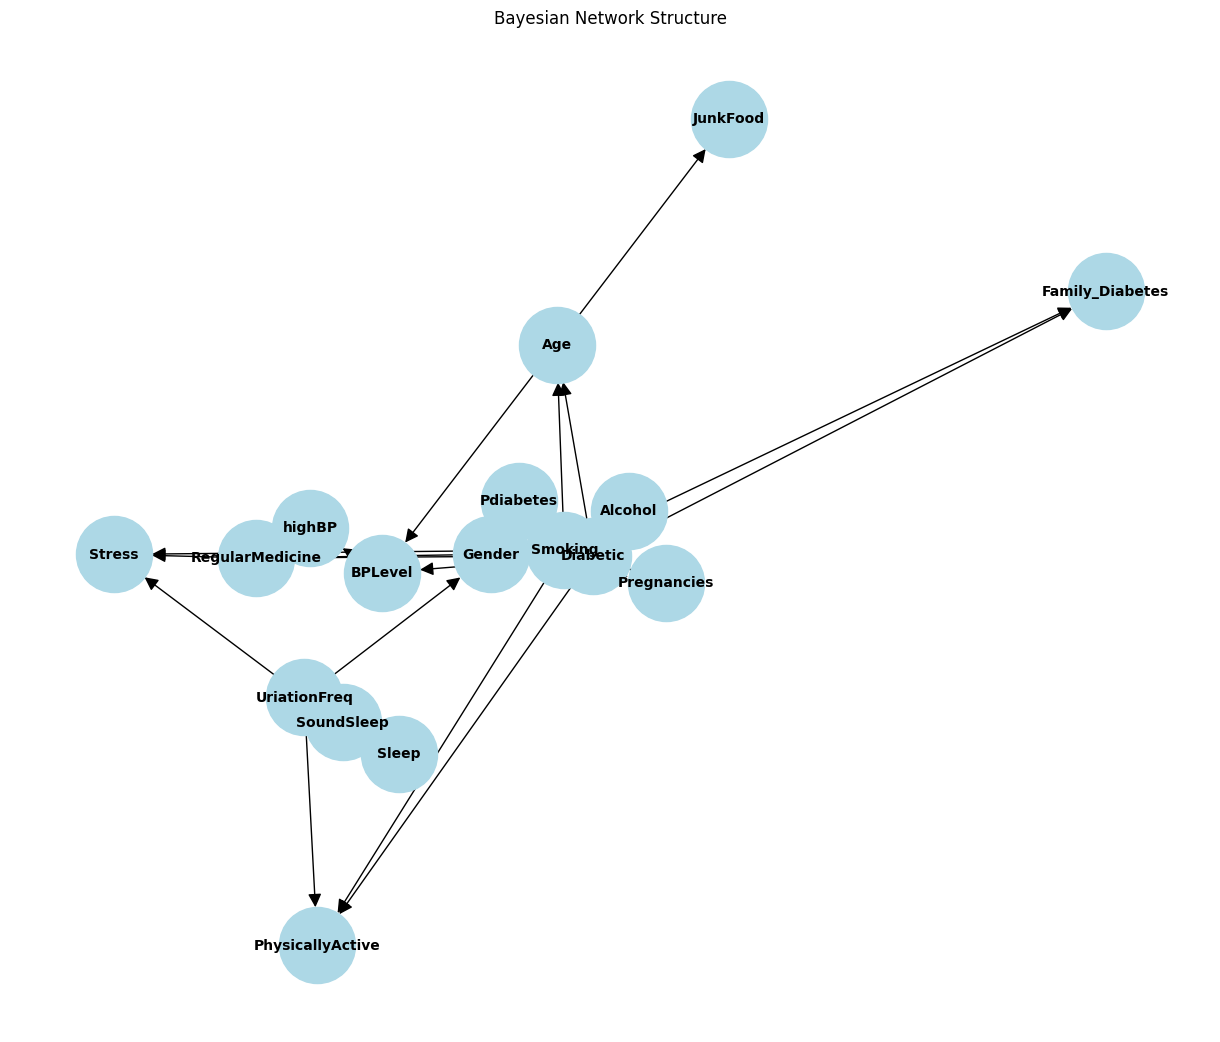

Fitting the Bayesian Network with data...


In [6]:

#only works for complete data
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data)
model = hc.estimate(scoring_method=BicScore(data))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [8]:
inference = VariableElimination(bayesian_net)

# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["PhysicallyActive","Diabetic"])
print("\nJoint Probability")
print(query_result)



Joint Probability
+---------------------+-------------+----------------------------------+
| PhysicallyActive    | Diabetic    |   phi(PhysicallyActive,Diabetic) |
+=====================+=============+==================================+
| PhysicallyActive(0) | Diabetic(0) |                           0.2653 |
+---------------------+-------------+----------------------------------+
| PhysicallyActive(0) | Diabetic(1) |                           0.0870 |
+---------------------+-------------+----------------------------------+
| PhysicallyActive(1) | Diabetic(0) |                           0.2099 |
+---------------------+-------------+----------------------------------+
| PhysicallyActive(1) | Diabetic(1) |                           0.0696 |
+---------------------+-------------+----------------------------------+
| PhysicallyActive(2) | Diabetic(0) |                           0.0794 |
+---------------------+-------------+----------------------------------+
| PhysicallyActive(2) | Diabetic

In [9]:
result = inference.query(variables=["PhysicallyActive"], evidence={"Diabetic": True})
print("Conditional Probability P(PhysicallyActive | Diabetic = True):")
print(result)

Conditional Probability P(PhysicallyActive | Diabetic = True):
+---------------------+-------------------------+
| PhysicallyActive    |   phi(PhysicallyActive) |
+=====================+=========================+
| PhysicallyActive(0) |                  0.2997 |
+---------------------+-------------------------+
| PhysicallyActive(1) |                  0.2399 |
+---------------------+-------------------------+
| PhysicallyActive(2) |                  0.2056 |
+---------------------+-------------------------+
| PhysicallyActive(3) |                  0.2548 |
+---------------------+-------------------------+


In [10]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['Age', 'BPLevel', 'JunkFood', 'Gender', 'Pregnancies', 'Alcohol', 'Smoking', 'RegularMedicine', 'highBP', 'Stress', 'Family_Diabetes', 'PhysicallyActive', 'Sleep', 'SoundSleep', 'UriationFreq', 'Diabetic', 'Pdiabetes']
Edges in the Bayesian Network:
[('Age', 'BPLevel'), ('Age', 'JunkFood'), ('BPLevel', 'highBP'), ('Gender', 'Pregnancies'), ('Gender', 'Alcohol'), ('Gender', 'Smoking'), ('Gender', 'RegularMedicine'), ('Pregnancies', 'Diabetic'), ('Alcohol', 'Smoking'), ('Smoking', 'Age'), ('Smoking', 'Stress'), ('Smoking', 'Family_Diabetes'), ('Smoking', 'PhysicallyActive'), ('RegularMedicine', 'Stress'), ('highBP', 'RegularMedicine'), ('Sleep', 'SoundSleep'), ('SoundSleep', 'UriationFreq'), ('UriationFreq', 'PhysicallyActive'), ('UriationFreq', 'Gender'), ('UriationFreq', 'Stress'), ('Diabetic', 'RegularMedicine'), ('Diabetic', 'Age'), ('Diabetic', 'Family_Diabetes'), ('Diabetic', 'Alcohol'), ('Diabetic', 'BPLevel'), ('Diabetic', 'PhysicallyActive'), ('Pd